# Test

We test the IAST code with a binary mixture of Xe and Kr in IRMOF-1.

Simulated pure component adsorption isotherms at 298 K are present in:
* IRMOF-1_clean_Xe_isotherm_298K.csv
* IRMOF-1_clean_Kr_isotherm_298K.csv

We ran dual component GCMC mixture isotherms of Xe/Kr in IRMOF-1 at 1 bar total pressure and different mixture conditions. This data is present in mixture_Xe_Kr_IRMOF-1_clean_298K.csv.

In [1]:
import IAST
import pandas as pd
import matplotlib
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
plt.style.use('bmh')
matplotlib.rc('axes', facecolor='w') # Or any suitable colour...
matplotlib.rc('lines',linewidth=3)
matplotlib.rc('font', size=18)

%matplotlib inline
%pylab inline


Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python2.7/dist-packages/pandas/computation/expressions.py:21: UserWarning: The installed version of numexpr 1.4.2 is not supported in pandas and will be not be used
The minimum supported version is 2.1

  "version is 2.1\n".format(ver=ver), UserWarning)


## Load pure component Xe and Kr isotherms as Pandas dataframes

In [2]:
df_Xe = pd.read_csv("IRMOF-1_Xe_isotherm_298K.csv")
df_Xe.head()

,Pressure(bar),Loading(mol/m3)
0,0.000001,0.000963
1,0.000002,0.002408
2,0.000004,0.003372
3,0.000005,0.005780
4,0.000006,0.001927


In [3]:
df_Kr = pd.read_csv("IRMOF-1_Kr_isotherm_298K.csv")
df_Kr.head()

,Pressure(bar),Loading(mol/m3)
0,0.000001,0.000000
1,0.000002,0.000963
2,0.000004,0.000482
3,0.000005,0.000963
4,0.000006,0.000482


Look at pure component isotherms to see that they reach saturation

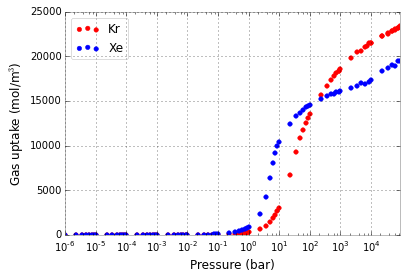

In [4]:
fig = plt.figure()
plt.xlabel('Pressure (bar)')
plt.ylabel('Gas uptake (mol/m$^3\!$)')
plt.scatter(df_Kr['Pressure(bar)'], df_Kr['Loading(mol/m3)'], color='r', label='Kr')
plt.scatter(df_Xe['Pressure(bar)'], df_Xe['Loading(mol/m3)'], color='b', label='Xe')
plt.xlim([df_Kr['Pressure(bar)'].min(), df_Kr['Pressure(bar)'].max()])
# plt.xlim(xmin=0)
plt.ylim(ymin=0)
plt.xscale("log")
plt.legend(loc='upper left')
plt.show()

## Load dual-component GCMC mixture isotherms

In [5]:
df_mix = pd.read_csv("mixture_Xe_Kr_IRMOF-1_clean_298K.csv", skiprows=1)
# define mole fraction Xe in gas phase
df_mix["y_Xe"] = df_mix["Xe_fug(Pa)"] / (df_mix["Xe_fug(Pa)"] + df_mix["Kr_fug(Pa)"])
df_mix.head()

,Xe_fug(Pa),Kr_fug(Pa),Xe_loading(mol/m3),Kr_loading(mol/m3),y_Xe
0,10000,90000,81.939715,259.767664,0.1
1,20000,80000,165.813861,232.605673,0.2
2,30000,70000,250.640773,203.088263,0.3
3,40000,60000,334.533223,173.518349,0.4
4,50000,50000,418.326928,147.291301,0.5


Viz

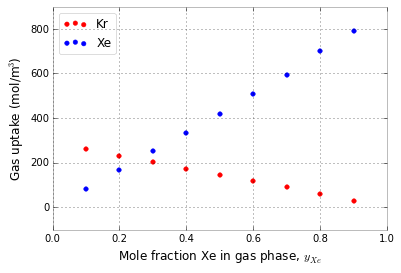

In [6]:
fig = plt.figure()
plt.xlabel('Mole fraction Xe in gas phase, $y_{Xe}$')
plt.ylabel('Gas uptake (mol/m$^3\!$)')
plt.scatter(df_mix['y_Xe'], df_mix['Kr_loading(mol/m3)'], color='r', label='Kr')
plt.scatter(df_mix['y_Xe'], df_mix['Xe_loading(mol/m3)'], color='b', label='Xe')
plt.legend(loc='upper left')
plt.show()

## Use IAST to predict mixture data, compare to dual component GCMC

Construct isotherm objects. Use the interpolator isotherm here, as Langmuir and Quadratic isotherms do not fit well.

We use fill_value = largest loading so that, when the linear interpolation routine calls a pressure beyond our data, it will yield this value. Essentially, the assumption is that the saturation loading = the loading for this last point.

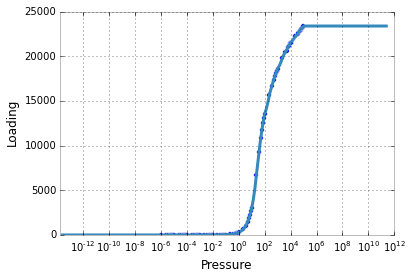

In [7]:
xe_isotherm = IAST.InterpolatorIsotherm(df_Xe, loading_key="Loading(mol/m3)", pressure_key="Pressure(bar)", fill_value=df_Xe["Loading(mol/m3)"].max())
kr_isotherm = IAST.InterpolatorIsotherm(df_Kr, loading_key="Loading(mol/m3)", pressure_key="Pressure(bar)", fill_value=df_Kr["Loading(mol/m3)"].max())
IAST.plot_isotherm(kr_isotherm,xlogscale=True)

Perform IAST at mixture conditions above

In [8]:
n_mixtures = df_mix.shape[0]
q = np.zeros((2, n_mixtures))  # store component loadings here

for i in range(n_mixtures):
    p = [df_mix["y_Xe"].iloc[i], 1.0 - df_mix["y_Xe"].iloc[i]]
    q[:, i] = IAST.IAST(p, [xe_isotherm, kr_isotherm], verboseflag=False)

## Compare IAST loadings to mixture isotherms

In the following plot, the points are the dual component GCMC simulation loadings at the respective Xe mole fraction in the gas phase. The lines are the result of the IAST calculation. The IAST calculations match the binary GCMC simulations very well.

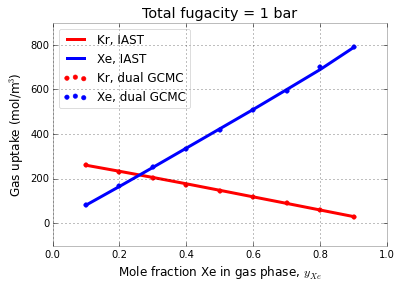

In [9]:
fig = plt.figure()
plt.xlabel('Mole fraction Xe in gas phase, $y_{Xe}$')
plt.ylabel('Gas uptake (mol/m$^3\!$)')
plt.scatter(df_mix['y_Xe'], df_mix['Kr_loading(mol/m3)'], color='r', label='Kr, dual GCMC')
plt.scatter(df_mix['y_Xe'], df_mix['Xe_loading(mol/m3)'], color='b', label='Xe, dual GCMC')
plt.plot(df_mix['y_Xe'], q[1, :], color='r', label='Kr, IAST')
plt.plot(df_mix['y_Xe'], q[0, :], color='b', label='Xe, IAST')
plt.legend(loc='upper left')
plt.title('Total fugacity = 1 bar')
plt.savefig('../docs/validation.png')
plt.show()

## Another sanity check

We use IAST for a three-component mixture of .5 bar Kr (all the same!). This should yield the loading at 1.5 bar.

In [10]:
# Nice test where all components are involved
q = IAST.IAST([.5,.5,.5], [kr_isotherm, kr_isotherm, kr_isotherm], verboseflag=False)
print "Sum of loadings: ", np.sum(q)
print "Loading at 1.5 bar: ", kr_isotherm.loading(1.5)

Sum of loadings:  434.919874634
Loading at 1.5 bar:  434.919874634


## Reverse IAST

In reverse IAST, we specify the mole fraction in the adsorbed phase and calculate the mole fractions in the gas phase that will yield these adsorbed phase mole fractions. We will test this using the dual GCMC Xe/Kr simulations. We define the mole fraction in the adsorbed phase $z_{Xe}$ below. ($z_{Kr} = 1- z_{Xe}$).

In [11]:
df_mix['z_Xe'] = df_mix['Xe_loading(mol/m3)'] / (df_mix['Xe_loading(mol/m3)'] + df_mix['Kr_loading(mol/m3)'])
df_mix.head()

,Xe_fug(Pa),Kr_fug(Pa),Xe_loading(mol/m3),Kr_loading(mol/m3),y_Xe,z_Xe
0,10000,90000,81.939715,259.767664,0.1,0.239795
1,20000,80000,165.813861,232.605673,0.2,0.416179
2,30000,70000,250.640773,203.088263,0.3,0.552402
3,40000,60000,334.533223,173.518349,0.4,0.658463
4,50000,50000,418.326928,147.291301,0.5,0.739592


In [12]:
n_mixtures = df_mix.shape[0]
y = np.zeros((2, n_mixtures))  # store bulk gas mole fractions here
q = np.zeros((2, n_mixtures))  # store component loadings here
P_total = 1.0  # bar, same units as in xe_isotherm and kr_isotherm
for i in range(n_mixtures):
    z = [df_mix['z_Xe'].iloc[i], 1.0 - df_mix['z_Xe'].iloc[i]]
    y[:, i], q[:, i] = IAST.reverse_IAST(z, P_total, [xe_isotherm, kr_isotherm])

array([ 0.10030359,  0.20076125,  0.30244208,  0.40311978,  0.4981251 ,
        0.59903437,  0.69777386,  0.80430093,  0.90052486])

The IAST prediction matches the dual component GCMC simulations.

In the first plot, we show the desired mole fraction in the adsorbed phase $z_{Xe}$ on the $x$-axis and the bulk gas phase mole fraction $y_{Xe}$ that yields this composition on the $y$-axis.

In the second plot, we compare the component loadings.

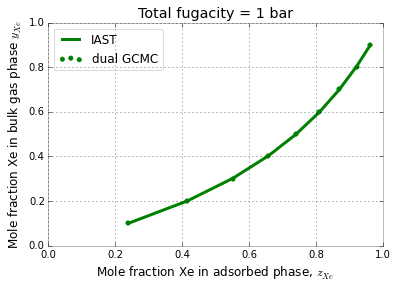

In [13]:
fig = plt.figure()
plt.xlabel('Mole fraction Xe in adsorbed phase, $z_{Xe}$')
plt.ylabel('Mole fraction Xe in bulk gas phase $y_{Xe}$')
plt.scatter(df_mix['z_Xe'], df_mix['y_Xe'], color='g', label='dual GCMC')
plt.plot(df_mix['z_Xe'].values, y[0, :], color='g', label='IAST')
plt.legend(loc='upper left')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.title('Total fugacity = 1 bar')
plt.savefig('reverse_validation.png', format='png')
plt.show() 

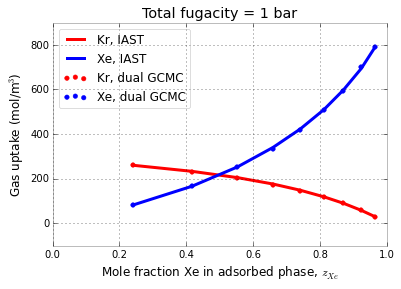

In [14]:
fig = plt.figure()
plt.xlabel('Mole fraction Xe in adsorbed phase, $z_{Xe}$')
plt.ylabel('Gas uptake (mol/m$^3\!$)')
plt.scatter(df_mix['z_Xe'], df_mix['Kr_loading(mol/m3)'], color='r', label='Kr, dual GCMC')
plt.scatter(df_mix['z_Xe'], df_mix['Xe_loading(mol/m3)'], color='b', label='Xe, dual GCMC')
plt.plot(df_mix['z_Xe'], q[1, :], color='r', label='Kr, IAST')
plt.plot(df_mix['z_Xe'], q[0, :], color='b', label='Xe, IAST')
plt.legend(loc='upper left')
plt.xlim([0, 1])
plt.title('Total fugacity = 1 bar')
plt.savefig('reverse_validation2.png', format='png')
plt.show() 